# Preprocesamiento de Datos: Prediccion de Podio en F1

## Objetivo
Este notebook implementa el pipeline completo de preprocesamiento de datos para el Modelo 4: **Prediccion de Podio (Top 3)** en carreras de Formula 1.

## Contenido
1. Carga y exploracion inicial de datos
2. Analisis de calidad de datos
3. Analisis de correlaciones y data leakage
4. Transformaciones y feature engineering
5. Balanceo de clases con SMOTE
6. Guardado de datasets procesados

## Dataset Final
- **Target**: `is_podium` (1 si posicion <= 3, 0 en caso contrario)
- **Features**: ~190 variables transformadas
- **Split**: Temporal (Train: hasta 2022, Test: 2023+)

---
## 1. Importar Librerias y Configuracion Inicial

In [30]:
%pip install pandas numpy matplotlib seaborn scikit-learn==1.5.2 category_encoders imbalanced-learn joblib scipy

INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 23.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2
  Attempting uninstall: category_encoders
    Found existing installation: category_encoders 2.8.1
    Uninstalling category_encoders-2.8.1:
      Successfully uninstalled category_encoders-2.8.1

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
# Librerias basicas
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
import joblib

# Estadisticas
from scipy import stats

print("Librerias importadas correctamente")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Librerias importadas correctamente
Pandas version: 2.3.3
NumPy version: 2.3.4


In [34]:
# Configuracion
BASE_PATH = "data/01_raw/"
OUTPUT_PATH = "data/processed/"
SPLIT_DATE = '2023-01-01'  # Train: hasta 2022, Test: 2023+

# Crear directorio de salida
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Configuracion de visualizacion
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Configuracion establecida")
print(f"Ruta de datos: {BASE_PATH}")
print(f"Ruta de salida: {OUTPUT_PATH}")
print(f"Fecha de corte: {SPLIT_DATE}")

Configuracion establecida
Ruta de datos: data/01_raw/
Ruta de salida: data/processed/
Fecha de corte: 2023-01-01


---
## 2. Carga de Datos y Exploracion Inicial

In [35]:
# Cargar datasets
print("Cargando datasets...")

race_results = pd.read_csv(f'{BASE_PATH}Race_Results.csv', na_values=['\\N'])
qualifying = pd.read_csv(f'{BASE_PATH}Qualifying_Results.csv', na_values=['\\N'])
races = pd.read_csv(f'{BASE_PATH}Race_Schedule.csv', na_values=['\\N'])
drivers = pd.read_csv(f'{BASE_PATH}Driver_Details.csv', na_values=['\\N'])
constructors = pd.read_csv(f'{BASE_PATH}Team_Details.csv', na_values=['\\N'])
circuits = pd.read_csv(f'{BASE_PATH}Track_Information.csv', na_values=['\\N'])

print("\nDatos cargados:")
print(f"  Race_Results: {len(race_results):,} registros, {len(race_results.columns)} columnas")
print(f"  Qualifying: {len(qualifying):,} registros, {len(qualifying.columns)} columnas")
print(f"  Races: {len(races):,} registros, {len(races.columns)} columnas")
print(f"  Drivers: {len(drivers):,} registros, {len(drivers.columns)} columnas")
print(f"  Constructors: {len(constructors):,} registros, {len(constructors.columns)} columnas")
print(f"  Circuits: {len(circuits):,} registros, {len(circuits.columns)} columnas")

Cargando datasets...

Datos cargados:
  Race_Results: 26,519 registros, 18 columnas
  Qualifying: 10,254 registros, 9 columnas
  Races: 1,125 registros, 18 columnas
  Drivers: 859 registros, 9 columnas
  Constructors: 212 registros, 5 columnas
  Circuits: 77 registros, 9 columnas


### 2.1 Exploracion de Race Results (Dataset Principal)

In [36]:
# Primeras filas
print("Primeras 5 filas de Race_Results:")
display(race_results.head())

print("\nInformacion del dataset:")
race_results.info()

Primeras 5 filas de Race_Results:


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1



Informacion del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26519 entries, 0 to 26518
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         26519 non-null  int64  
 1   raceId           26519 non-null  int64  
 2   driverId         26519 non-null  int64  
 3   constructorId    26519 non-null  int64  
 4   number           26513 non-null  float64
 5   grid             26519 non-null  int64  
 6   position         15591 non-null  float64
 7   positionText     26519 non-null  object 
 8   positionOrder    26519 non-null  int64  
 9   points           26519 non-null  float64
 10  laps             26519 non-null  int64  
 11  time             7533 non-null   object 
 12  milliseconds     7533 non-null   float64
 13  fastestLap       8020 non-null   float64
 14  rank             8270 non-null   float64
 15  fastestLapTime   8020 non-null   object 
 16  fastestLapSpeed  8020 non-null  

In [37]:
# Estadisticas descriptivas
print("Estadisticas descriptivas de variables numericas:")
display(race_results.describe())

Estadisticas descriptivas de variables numericas:


,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,statusId
count,26519.000000,26519.000000,26519.000000,26519.000000,26513.000000,26519.000000,15591.000000,26519.000000,26519.000000,26519.000000,7.533000e+03,8020.000000,8270.000000,8020.000000,26519.000000
mean,13260.940986,546.376560,274.357291,49.801161,18.047712,11.145820,7.999743,12.814812,1.959578,46.228251,6.208717e+06,42.616708,10.348489,203.924284,17.317056
std,7656.813206,309.642244,279.275606,61.091426,15.455819,7.213453,4.831278,7.677869,4.306475,29.577860,1.653592e+06,16.662498,6.149817,21.358410,26.081700
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.070710e+05,1.000000,0.000000,89.540000,1.000000
25%,6630.500000,298.000000,57.000000,6.000000,7.000000,5.000000,4.000000,6.000000,0.000000,23.000000,5.383181e+06,33.000000,5.000000,193.367000,1.000000
50%,13260.000000,527.000000,170.000000,25.000000,16.000000,11.000000,7.000000,12.000000,0.000000,53.000000,5.796882e+06,46.000000,10.000000,204.935000,10.000000
75%,19889.500000,803.000000,385.000000,60.000000,24.000000,17.000000,11.000000,18.000000,2.000000,66.000000,6.415351e+06,54.000000,15.000000,217.108750,14.000000
max,26524.000000,1132.000000,860.000000,215.000000,208.000000,34.000000,33.000000,39.000000,50.000000,200.000000,1.509054e+07,85.000000,24.000000,257.320000,141.000000


### 2.2 Analisis de Valores Faltantes

In [38]:
# Calcular porcentaje de valores faltantes
missing_data = pd.DataFrame({
    'Columna': race_results.columns,
    'Faltantes': race_results.isnull().sum(),
    'Porcentaje': (race_results.isnull().sum() / len(race_results) * 100).round(2)
}).sort_values('Porcentaje', ascending=False)

missing_data = missing_data[missing_data['Faltantes'] > 0]

print(f"\nColumnas con valores faltantes: {len(missing_data)}")
display(missing_data)


Columnas con valores faltantes: 8


,Columna,Faltantes,Porcentaje
time,time,18986,71.59
milliseconds,milliseconds,18986,71.59
fastestLapSpeed,fastestLapSpeed,18499,69.76
fastestLap,fastestLap,18499,69.76
fastestLapTime,fastestLapTime,18499,69.76
rank,rank,18249,68.81
position,position,10928,41.21
number,number,6,0.02


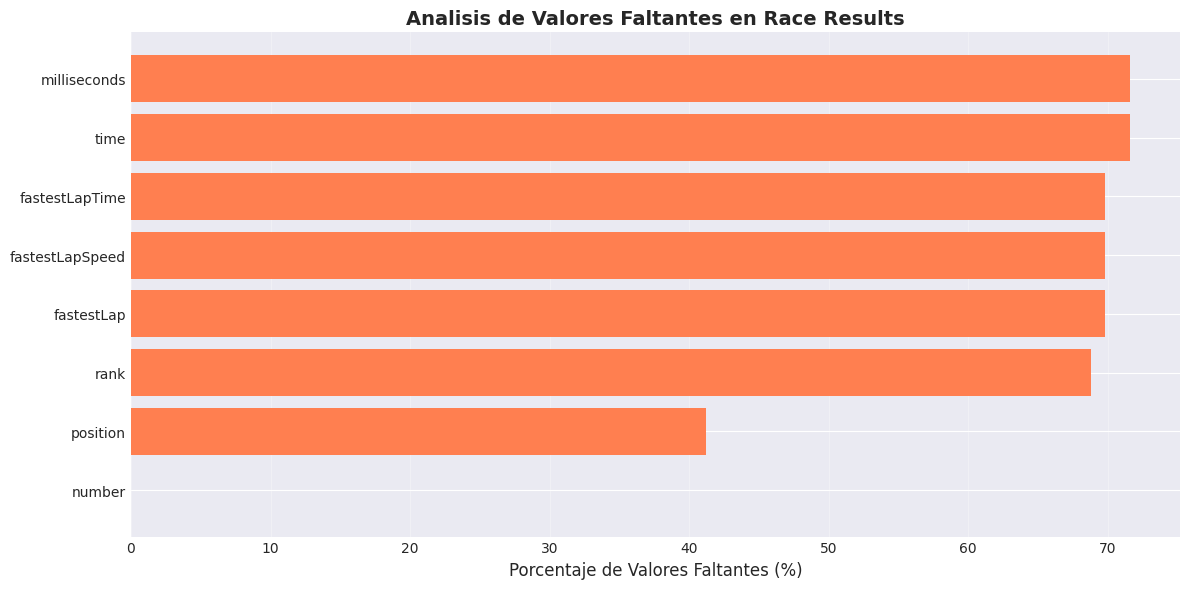

In [39]:
# Visualizacion de valores faltantes
if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Grafico de barras horizontal
    missing_data_sorted = missing_data.sort_values('Porcentaje')
    ax.barh(missing_data_sorted['Columna'], missing_data_sorted['Porcentaje'], color='coral')
    
    ax.set_xlabel('Porcentaje de Valores Faltantes (%)', fontsize=12)
    ax.set_title('Analisis de Valores Faltantes en Race Results', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No hay valores faltantes en el dataset")

### 2.3 Filtrado de Registros Validos

**Criterio**: Solo incluir pilotos que terminaron la carrera (con posicion valida). Esto excluye:
- Pilotos retirados (DNF)
- Pilotos descalificados
- Registros sin posicion

Registros ANTES del filtro: 26,519
Registros DESPUES del filtro: 15,591
Registros eliminados: 10,928 (41.21%)


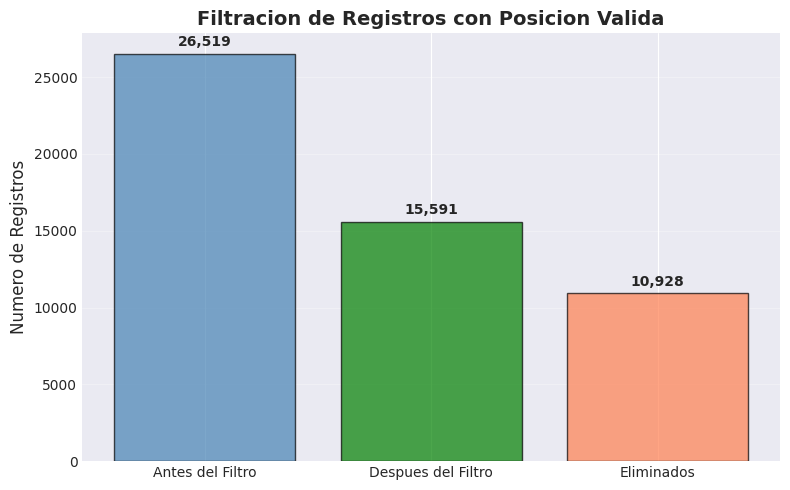

In [40]:
print(f"Registros ANTES del filtro: {len(race_results):,}")

# Filtrar solo registros con posicion valida
race_results_filtered = race_results[race_results['position'].notna()].copy()

print(f"Registros DESPUES del filtro: {len(race_results_filtered):,}")
print(f"Registros eliminados: {len(race_results) - len(race_results_filtered):,} ({100 * (len(race_results) - len(race_results_filtered)) / len(race_results):.2f}%)")

# Visualizacion
fig, ax = plt.subplots(figsize=(8, 5))
categories = ['Antes del Filtro', 'Despues del Filtro', 'Eliminados']
values = [
    len(race_results),
    len(race_results_filtered),
    len(race_results) - len(race_results_filtered)
]
colors = ['steelblue', 'green', 'coral']

ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Numero de Registros', fontsize=12)
ax.set_title('Filtracion de Registros con Posicion Valida', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(values):
    ax.text(i, v + 500, f'{v:,}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 3. Creacion de Variable Target: `is_podium`

**Definicion**: Un piloto logra podio si termina en posicion 1, 2 o 3.
- `is_podium = 1`: Posicion <= 3
- `is_podium = 0`: Posicion > 3

In [41]:
# Crear variable target
race_results_filtered['is_podium'] = (race_results_filtered['position'] <= 3).astype(int)

# Guardar posicion original para features derivadas
race_results_filtered['position_original'] = race_results_filtered['position']

print("Variable 'is_podium' creada exitosamente")
print("\nDistribucion de la variable target:")
print(race_results_filtered['is_podium'].value_counts())

Variable 'is_podium' creada exitosamente

Distribucion de la variable target:
is_podium
0    12231
1     3360
Name: count, dtype: int64


### 3.1 Analisis de Balance de Clases

In [42]:
# Calcular balance
podium_counts = race_results_filtered['is_podium'].value_counts()
podium_pcts = race_results_filtered['is_podium'].value_counts(normalize=True) * 100

print("Balance de Clases:")
print(f"  Clase 0 (No Podio): {podium_counts[0]:,} registros ({podium_pcts[0]:.2f}%)")
print(f"  Clase 1 (Podio): {podium_counts[1]:,} registros ({podium_pcts[1]:.2f}%)")
print(f"\nRatio de desbalance: 1:{podium_counts[0]/podium_counts[1]:.2f}")
print(f"\nInterpretacion: Por cada piloto que logra podio, hay {podium_counts[0]/podium_counts[1]:.1f} pilotos que NO logran podio")

Balance de Clases:
  Clase 0 (No Podio): 12,231 registros (78.45%)
  Clase 1 (Podio): 3,360 registros (21.55%)

Ratio de desbalance: 1:3.64

Interpretacion: Por cada piloto que logra podio, hay 3.6 pilotos que NO logran podio


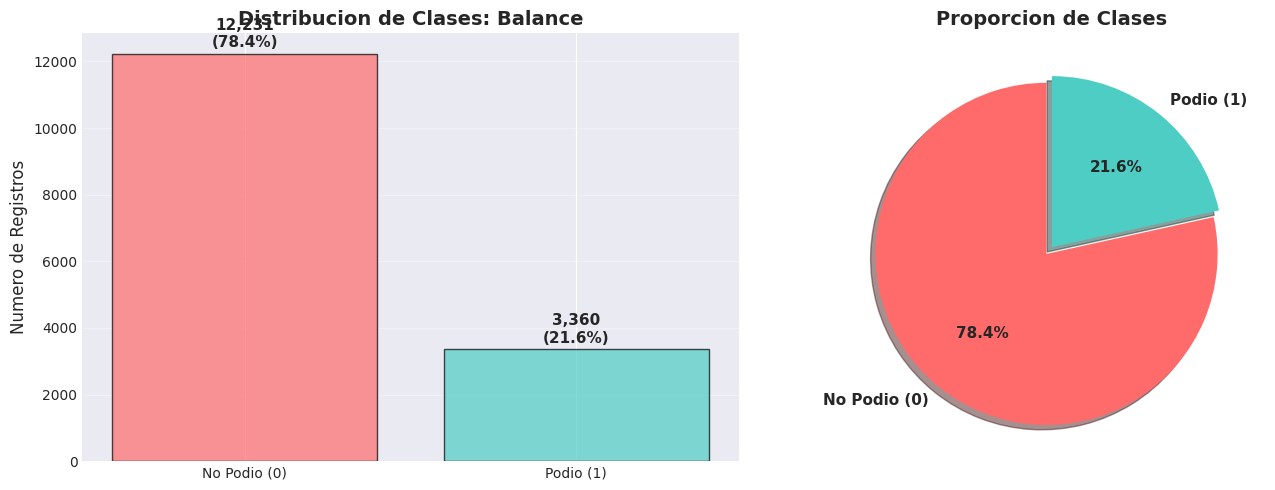


CONCLUSION: Existe un DESBALANCE SIGNIFICATIVO (78% vs 22%)
Estrategias a aplicar: SMOTE, class_weight, scale_pos_weight


In [43]:
# Visualizacion del balance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico de barras
colors_bar = ['#FF6B6B', '#4ECDC4']
axes[0].bar(['No Podio (0)', 'Podio (1)'], podium_counts.values, color=colors_bar, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Numero de Registros', fontsize=12)
axes[0].set_title('Distribucion de Clases: Balance', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores
for i, v in enumerate(podium_counts.values):
    axes[0].text(i, v + 200, f'{v:,}\n({podium_pcts.values[i]:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# Grafico de torta
colors_pie = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0)
axes[1].pie(podium_counts.values, 
           labels=['No Podio (0)', 'Podio (1)'],
           autopct='%1.1f%%',
           colors=colors_pie,
           explode=explode,
           shadow=True,
           startangle=90,
           textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Proporcion de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nCONCLUSION: Existe un DESBALANCE SIGNIFICATIVO (78% vs 22%)")
print("Estrategias a aplicar: SMOTE, class_weight, scale_pos_weight")

---
## 4. Identificacion y Eliminacion de Data Leakage

**Data Leakage**: Variables que contienen informacion del futuro o que dependen directamente del resultado.

### Variables a Eliminar (12 variables):
1. `position`: Es el target transformado
2. `positionOrder`: Equivalente a position
3. `positionText`: Texto de position
4. `points`: Depende de position
5. `time`: Tiempo total de carrera
6. `milliseconds`: Tiempo en ms
7. `statusId`: Estado final (relacionado con abandonos)
8. `laps`: Vueltas completadas
9. `rank`: Ranking de vuelta rapida
10. `fastestLapTime`: Tiempo de vuelta rapida
11. `fastestLapSpeed`: Velocidad maxima
12. `fastestLap`: Numero de vuelta rapida

In [44]:
# Variables con data leakage
leakage_vars = [
    'position', 'positionOrder', 'positionText',
    'points',
    'time', 'milliseconds',
    'statusId', 'laps',
    'rank', 'fastestLapTime', 'fastestLapSpeed', 'fastestLap'
]

print(f"Variables identificadas con data leakage: {len(leakage_vars)}")
print("\nListado:")
for i, var in enumerate(leakage_vars, 1):
    print(f"  {i}. {var}")

# Eliminar variables (excepto position_original que guardamos)
vars_to_drop = [v for v in leakage_vars if v in race_results_filtered.columns and v != 'position_original']
race_results_filtered = race_results_filtered.drop(columns=vars_to_drop)

print(f"\nVariables eliminadas: {len(vars_to_drop)}")
print(f"Columnas restantes: {len(race_results_filtered.columns)}")

Variables identificadas con data leakage: 12

Listado:
  1. position
  2. positionOrder
  3. positionText
  4. points
  5. time
  6. milliseconds
  7. statusId
  8. laps
  9. rank
  10. fastestLapTime
  11. fastestLapSpeed
  12. fastestLap

Variables eliminadas: 12
Columnas restantes: 8


---
## 5. Join de Tablas: Construccion del Dataset Completo

In [45]:
print("Realizando joins entre tablas...")

# Join principal con races
df = race_results_filtered.merge(
    races[['raceId', 'year', 'circuitId', 'name', 'round', 'date']],
    on='raceId',
    how='left'
)

print(f"  Despues de join con races: {len(df)} registros, {len(df.columns)} columnas")

# Join con Qualifying (renombrar position a position_quali para evitar conflicto)
qualifying_renamed = qualifying[['raceId', 'driverId', 'position', 'q1', 'q2', 'q3']].copy()
qualifying_renamed = qualifying_renamed.rename(columns={'position': 'position_quali'})
df = df.merge(
    qualifying_renamed,
    on=['raceId', 'driverId'],
    how='left'
)

print(f"  Despues de join con qualifying: {len(df)} registros, {len(df.columns)} columnas")

# Join con Circuits
df = df.merge(
    circuits[['circuitId', 'lat', 'lng', 'alt', 'location', 'country']],
    on='circuitId',
    how='left'
)

print(f"  Despues de join con circuits: {len(df)} registros, {len(df.columns)} columnas")

# Join con Drivers
df = df.merge(
    drivers[['driverId', 'dob', 'nationality']],
    on='driverId',
    how='left',
    suffixes=('', '_driver')
)

print(f"  Despues de join con drivers: {len(df)} registros, {len(df.columns)} columnas")

# Join con Constructors
df = df.merge(
    constructors[['constructorId', 'name', 'nationality']],
    on='constructorId',
    how='left',
    suffixes=('', '_constructor')
)

print(f"\nDataset FINAL despues de todos los joins:")
print(f"  Registros: {len(df):,}")
print(f"  Columnas: {len(df.columns)}")

# Mostrar primeras filas
print("\nPrimeras 3 filas del dataset unificado:")
display(df.head(3))

Realizando joins entre tablas...
  Despues de join con races: 15591 registros, 13 columnas
  Despues de join con qualifying: 15591 registros, 17 columnas
  Despues de join con circuits: 15591 registros, 22 columnas
  Despues de join con drivers: 15591 registros, 24 columnas

Dataset FINAL despues de todos los joins:
  Registros: 15,591
  Columnas: 26

Primeras 3 filas del dataset unificado:


,resultId,raceId,driverId,constructorId,number,grid,is_podium,position_original,year,circuitId,...,q3,lat,lng,alt,location,country,dob,nationality,name_constructor,nationality_constructor
0,1,18,1,1,22.0,1,1,1.0,2008,1,...,1:26.714,-37.8497,144.968,10,Melbourne,Australia,1985-01-07,British,McLaren,British
1,2,18,2,2,3.0,5,1,2.0,2008,1,...,1:27.236,-37.8497,144.968,10,Melbourne,Australia,1977-05-10,German,BMW Sauber,German
2,3,18,3,3,7.0,7,1,3.0,2008,1,...,1:28.687,-37.8497,144.968,10,Melbourne,Australia,1985-06-27,German,Williams,British


---
## 6. Ordenamiento Temporal (CRITICO para prevenir data leakage)

In [46]:
# Convertir fecha a datetime
df['date'] = pd.to_datetime(df['date'])

# Ordenar cronologicamente
df = df.sort_values(['date', 'raceId']).reset_index(drop=True)

print("Dataset ordenado cronologicamente")
print(f"Fecha minima: {df['date'].min()}")
print(f"Fecha maxima: {df['date'].max()}")
print(f"Rango: {(df['date'].max() - df['date'].min()).days / 365.25:.1f} años")

Dataset ordenado cronologicamente
Fecha minima: 1950-05-13 00:00:00
Fecha maxima: 2024-07-07 00:00:00
Rango: 74.2 años


---
## 7. Feature Engineering: Creacion de Features Derivadas

### 7.1 Features Historicas del Piloto

**Importante**: Usar `.shift(1)` para evitar data leakage temporal

In [47]:
print("Creando features historicas del piloto...")

# 1. Podios en ultimas 5 carreras
df['driver_podiums_last_5'] = df.groupby('driverId')['is_podium'].transform(
    lambda x: x.rolling(window=5, min_periods=1).sum().shift(1)
).fillna(0)

# 2. Tasa de podio en la temporada actual
df['driver_podium_rate_season'] = df.groupby(['driverId', 'year'])['is_podium'].transform(
    lambda x: x.expanding().mean().shift(1)
).fillna(0)

# 3. Victorias en la temporada
df['driver_wins_season'] = df.groupby(['driverId', 'year'])['position_original'].transform(
    lambda x: (x == 1).astype(float).cumsum().shift(1)
).fillna(0)

print("Features del piloto creadas:")
print("  - driver_podiums_last_5")
print("  - driver_podium_rate_season")
print("  - driver_wins_season")

Creando features historicas del piloto...
Features del piloto creadas:
  - driver_podiums_last_5
  - driver_podium_rate_season
  - driver_wins_season


### 7.2 Features Historicas del Constructor (Escuderia)

In [48]:
print("Creando features historicas del constructor...")

# 1. Podios en ultimas 5 carreras
df['constructor_podiums_last_5'] = df.groupby('constructorId')['is_podium'].transform(
    lambda x: x.rolling(window=5, min_periods=1).sum().shift(1)
).fillna(0)

# 2. Tasa de podio en la temporada
df['constructor_podium_rate_season'] = df.groupby(['constructorId', 'year'])['is_podium'].transform(
    lambda x: x.expanding().mean().shift(1)
).fillna(0)

print("Features del constructor creadas:")
print("  - constructor_podiums_last_5")
print("  - constructor_podium_rate_season")

Creando features historicas del constructor...
Features del constructor creadas:
  - constructor_podiums_last_5
  - constructor_podium_rate_season


### 7.3 Features de Qualifying y Temporales

In [49]:
print("Creando features de qualifying y temporales...")

# Features de qualifying
df['quali_position_top3'] = (df['position_quali'] <= 3).astype(int)
df['quali_position_top5'] = (df['position_quali'] <= 5).astype(int)

# Edad del piloto
df['driver_age'] = df['year'] - pd.to_datetime(df['dob']).dt.year

# Progreso de la temporada
max_round_per_season = df.groupby('year')['round'].transform('max')
df['season_progress'] = df['round'] / max_round_per_season
df['is_season_start'] = (df['round'] <= 3).astype(int)
df['is_season_end'] = (df['round'] >= max_round_per_season - 2).astype(int)

print("Features adicionales creadas:")
print("  - quali_position_top3, quali_position_top5")
print("  - driver_age")
print("  - season_progress, is_season_start, is_season_end")

print(f"\nTotal de columnas: {len(df.columns)}")

Creando features de qualifying y temporales...
Features adicionales creadas:
  - quali_position_top3, quali_position_top5
  - driver_age
  - season_progress, is_season_start, is_season_end

Total de columnas: 37


### 7.4 Visualizacion de Features Derivadas Clave

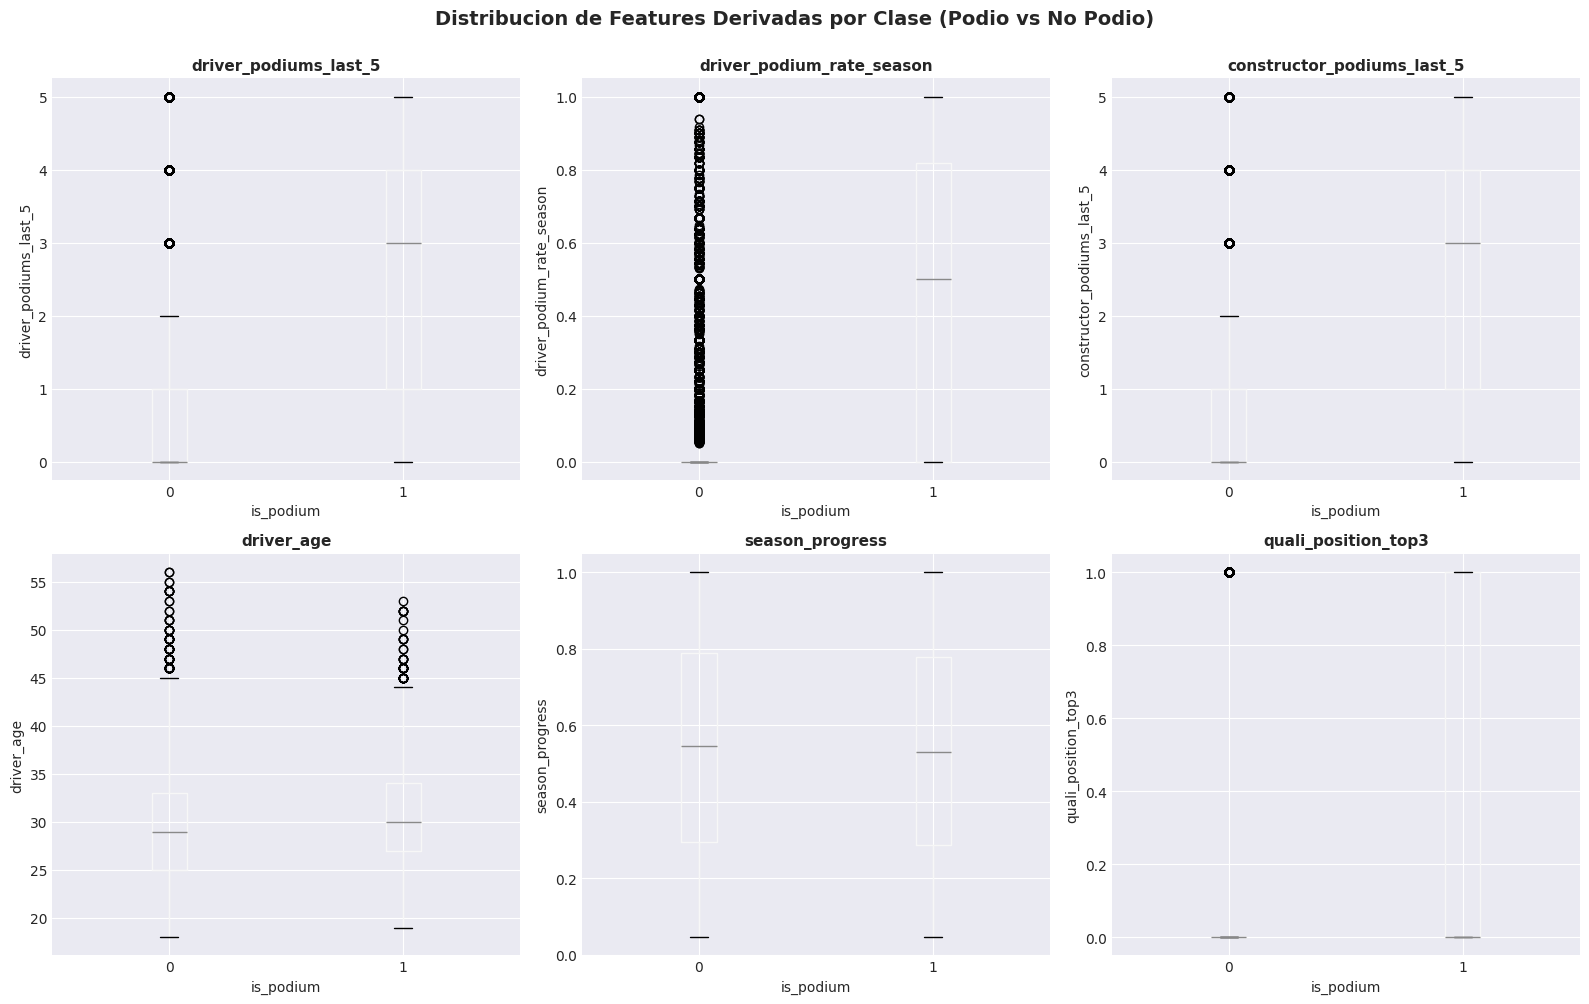

In [50]:
# Distribucion de features derivadas por clase
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

features_to_plot = [
    'driver_podiums_last_5',
    'driver_podium_rate_season',
    'constructor_podiums_last_5',
    'driver_age',
    'season_progress',
    'quali_position_top3'
]

for i, feature in enumerate(features_to_plot):
    # Boxplot por clase
    df.boxplot(column=feature, by='is_podium', ax=axes[i])
    axes[i].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('is_podium')
    axes[i].set_ylabel(feature)
    axes[i].get_figure().suptitle('')

plt.suptitle('Distribucion de Features Derivadas por Clase (Podio vs No Podio)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---
## 8. Transformacion de Tiempos de Qualifying

Convertir tiempos en formato 'M:SS.mmm' a milisegundos numericos

In [51]:
def time_to_milliseconds(time_str):
    """Convierte string 'M:SS.mmm' a milisegundos"""
    if pd.isna(time_str):
        return np.nan
    try:
        parts = str(time_str).split(':')
        if len(parts) != 2:
            return np.nan
        minutes = int(parts[0])
        seconds = float(parts[1])
        return (minutes * 60 + seconds) * 1000
    except:
        return np.nan

# Aplicar transformacion
print("Transformando tiempos de qualifying...")

df['q1_ms'] = df['q1'].apply(time_to_milliseconds)
df['q2_ms'] = df['q2'].apply(time_to_milliseconds)
df['q3_ms'] = df['q3'].apply(time_to_milliseconds)

# Crear flags binarios de participacion
df['has_q1'] = df['q1'].notna().astype(int)
df['has_q2'] = df['q2'].notna().astype(int)
df['has_q3'] = df['q3'].notna().astype(int)

print("Tiempos transformados exitosamente")
print(f"\nEjemplo de transformacion:")
sample = df[['q1', 'q1_ms', 'has_q1']].dropna(subset=['q1']).head(3)
display(sample)

Transformando tiempos de qualifying...
Tiempos transformados exitosamente

Ejemplo de transformacion:


,q1,q1_ms,has_q1
6670,1:16.290,76290.0,1
6671,1:17.554,77554.0,1
6672,1:17.385,77385.0,1


---
## 9. Imputacion de Valores Faltantes

In [52]:
print("Imputando valores faltantes...")

# 1. position_quali: Imputar con max + 1 por carrera (piloto partio ultimo)
max_quali_per_race = df.groupby('raceId')['position_quali'].transform('max')
df['position_quali'] = df['position_quali'].fillna(max_quali_per_race + 1)
df['position_quali'] = df['position_quali'].fillna(25)  # Valor por defecto si todo es NaN

print(f"  position_quali: Imputados {df['position_quali'].isnull().sum()} valores")

# 2. dob: Imputar con mediana
df['dob'] = pd.to_datetime(df['dob'])
median_dob = df['dob'].median()
df['dob'] = df['dob'].fillna(median_dob)
df['driver_age'] = df['year'] - df['dob'].dt.year

print(f"  dob: Imputados con mediana ({median_dob.date()})")

# Recalcular features que dependen de position_quali
df['quali_position_top3'] = (df['position_quali'] <= 3).astype(int)
df['quali_position_top5'] = (df['position_quali'] <= 5).astype(int)

print("\nImputacion completada")

Imputando valores faltantes...
  position_quali: Imputados 0 valores
  dob: Imputados con mediana (1971-01-18)

Imputacion completada


---
## 10. Split Temporal Train/Test

**Estrategia**: Split temporal para evitar data leakage
- **Train**: Carreras hasta 2022 (inclusive)
- **Test**: Carreras desde 2023 en adelante

In [53]:
print(f"Dividiendo dataset en Train/Test (fecha de corte: {SPLIT_DATE})...")

train_df = df[df['date'] < SPLIT_DATE].copy()
test_df = df[df['date'] >= SPLIT_DATE].copy()

print(f"\nDataset Train:")
print(f"  Registros: {len(train_df):,}")
print(f"  Fecha minima: {train_df['date'].min()}")
print(f"  Fecha maxima: {train_df['date'].max()}")

print(f"\nDataset Test:")
print(f"  Registros: {len(test_df):,}")
print(f"  Fecha minima: {test_df['date'].min()}")
print(f"  Fecha maxima: {test_df['date'].max()}")

# Verificar balance en train y test
train_balance = train_df['is_podium'].value_counts()
test_balance = test_df['is_podium'].value_counts()

print(f"\nBalance Train:")
print(f"  No Podio: {train_balance[0]:,} ({100*train_balance[0]/len(train_df):.2f}%)")
print(f"  Podio: {train_balance[1]:,} ({100*train_balance[1]/len(train_df):.2f}%)")

print(f"\nBalance Test:")
print(f"  No Podio: {test_balance[0]:,} ({100*test_balance[0]/len(test_df):.2f}%)")
print(f"  Podio: {test_balance[1]:,} ({100*test_balance[1]/len(test_df):.2f}%)")

Dividiendo dataset en Train/Test (fecha de corte: 2023-01-01)...

Dataset Train:
  Registros: 14,989
  Fecha minima: 1950-05-13 00:00:00
  Fecha maxima: 2022-11-20 00:00:00

Dataset Test:
  Registros: 602
  Fecha minima: 2023-03-05 00:00:00
  Fecha maxima: 2024-07-07 00:00:00

Balance Train:
  No Podio: 11,731 (78.26%)
  Podio: 3,258 (21.74%)

Balance Test:
  No Podio: 500 (83.06%)
  Podio: 102 (16.94%)


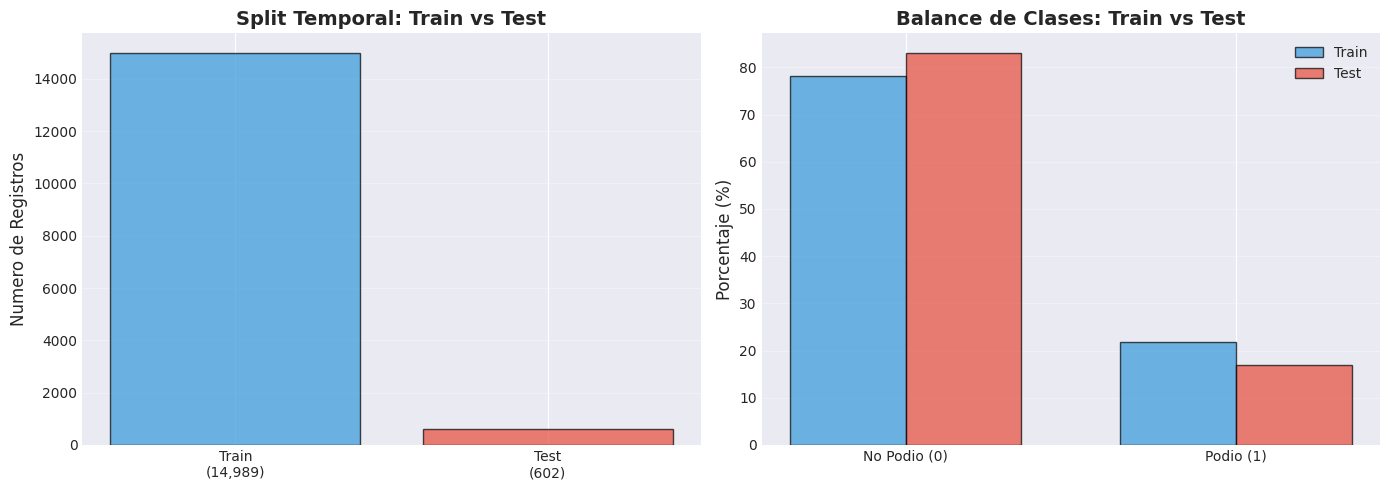

In [54]:
# Visualizacion del split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico 1: Tamaños de Train y Test
sizes = [len(train_df), len(test_df)]
labels = [f'Train\n({len(train_df):,})', f'Test\n({len(test_df):,})']
colors_split = ['#3498db', '#e74c3c']

axes[0].bar(labels, sizes, color=colors_split, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Numero de Registros', fontsize=12)
axes[0].set_title('Split Temporal: Train vs Test', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Grafico 2: Balance de clases en ambos conjuntos
x = np.arange(2)
width = 0.35

train_pcts = [100*train_balance[0]/len(train_df), 100*train_balance[1]/len(train_df)]
test_pcts = [100*test_balance[0]/len(test_df), 100*test_balance[1]/len(test_df)]

axes[1].bar(x - width/2, train_pcts, width, label='Train', color='#3498db', alpha=0.7, edgecolor='black')
axes[1].bar(x + width/2, test_pcts, width, label='Test', color='#e74c3c', alpha=0.7, edgecolor='black')

axes[1].set_ylabel('Porcentaje (%)', fontsize=12)
axes[1].set_title('Balance de Clases: Train vs Test', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Podio (0)', 'Podio (1)'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 11. Aplicacion de Transformaciones (Scaling y Encoding)

### 11.1 MinMaxScaler: Features Acotadas

In [55]:
# Features para MinMaxScaler (acotadas, rangos definidos)
minmax_features = [
    'grid', 'round', 'season_progress',
    'driver_podiums_last_5', 'constructor_podiums_last_5',
    'driver_podium_rate_season', 'constructor_podium_rate_season',
    'q1_ms', 'q2_ms', 'q3_ms'
]

print("Aplicando MinMaxScaler...")
print(f"Features a escalar: {len(minmax_features)}")

# Aplicar MinMaxScaler
minmax_scaler = MinMaxScaler()
train_df[minmax_features] = minmax_scaler.fit_transform(train_df[minmax_features].fillna(0))
test_df[minmax_features] = minmax_scaler.transform(test_df[minmax_features].fillna(0))

print("MinMaxScaler aplicado exitosamente")
print(f"\nRango despues de scaling: [0, 1]")
print(f"\nEjemplo (grid):")
print(f"  Min: {train_df['grid'].min():.4f}")
print(f"  Max: {train_df['grid'].max():.4f}")

Aplicando MinMaxScaler...
Features a escalar: 10
MinMaxScaler aplicado exitosamente

Rango despues de scaling: [0, 1]

Ejemplo (grid):
  Min: 0.0000
  Max: 1.0000


### 11.2 StandardScaler: Features con Distribucion Normal

In [56]:
# Features para StandardScaler
standard_features = ['lat', 'lng', 'alt', 'year', 'driver_age']

print("Aplicando StandardScaler...")
print(f"Features a estandarizar: {len(standard_features)}")

# Aplicar StandardScaler
standard_scaler = StandardScaler()
train_df[standard_features] = standard_scaler.fit_transform(train_df[standard_features].fillna(0))
test_df[standard_features] = standard_scaler.transform(test_df[standard_features].fillna(0))

print("StandardScaler aplicado exitosamente")
print(f"\nMedia despues de scaling: ~0")
print(f"Desviacion estandar: ~1")
print(f"\nEjemplo (driver_age):")
print(f"  Media: {train_df['driver_age'].mean():.4f}")
print(f"  Std: {train_df['driver_age'].std():.4f}")

Aplicando StandardScaler...
Features a estandarizar: 5
StandardScaler aplicado exitosamente

Media despues de scaling: ~0
Desviacion estandar: ~1

Ejemplo (driver_age):
  Media: 0.0000
  Std: 1.0000


### 11.3 Target Encoding: Variables de Alta Cardinalidad

In [57]:
# Features categoricas de alta cardinalidad
target_encoding_features = ['driverId', 'constructorId', 'circuitId']

print("Aplicando Target Encoding...")
print(f"\nCardinalidad de features:")
for feat in target_encoding_features:
    print(f"  {feat}: {train_df[feat].nunique()} valores unicos")

# Aplicar Target Encoding
target_encoder = TargetEncoder(smoothing=1.0)
for feat in target_encoding_features:
    train_df[f'{feat}_encoded'] = target_encoder.fit_transform(train_df[feat], train_df['is_podium'])
    test_df[f'{feat}_encoded'] = target_encoder.transform(test_df[feat])

print("\nTarget Encoding aplicado exitosamente")
print(f"Nuevas columnas creadas: {len(target_encoding_features)}")

Aplicando Target Encoding...

Cardinalidad de features:
  driverId: 653 valores unicos
  constructorId: 161 valores unicos
  circuitId: 76 valores unicos

Target Encoding aplicado exitosamente
Nuevas columnas creadas: 3


### 11.4 One-Hot Encoding: Variables Categoricas de Baja Cardinalidad

In [58]:
# Features categoricas de baja cardinalidad
onehot_features = ['location', 'country', 'nationality', 'nationality_constructor']

print("Aplicando One-Hot Encoding...")
print(f"\nCardinalidad de features:")
for feat in onehot_features:
    if feat in train_df.columns:
        print(f"  {feat}: {train_df[feat].nunique()} valores unicos")

# Aplicar One-Hot Encoding
train_df = pd.get_dummies(train_df, columns=onehot_features, drop_first=True, dtype=int)
test_df = pd.get_dummies(test_df, columns=onehot_features, drop_first=True, dtype=int)

# Alinear columnas entre train y test
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

print(f"\nOne-Hot Encoding aplicado")
print(f"Total de columnas despues de encoding: {len(train_df.columns)}")

Aplicando One-Hot Encoding...

Cardinalidad de features:
  location: 74 valores unicos
  country: 34 valores unicos
  nationality: 41 valores unicos
  nationality_constructor: 19 valores unicos

One-Hot Encoding aplicado
Total de columnas despues de encoding: 206


---
## 12. Preparacion Final de Datasets

In [59]:
print("Preparando datasets finales...")

# Columnas a eliminar
columns_to_drop = [
    'raceId', 'date', 'name', 'dob', 'q1', 'q2', 'q3',
    'driverId', 'constructorId', 'circuitId',
    'resultId', 'number', 'positionText',
    'position_original', 'position_quali',
    'is_podium'
]

# Preparar X (features) y y (target)
X_train = train_df.drop(columns=[c for c in columns_to_drop if c in train_df.columns], errors='ignore')
X_test = test_df.drop(columns=[c for c in columns_to_drop if c in test_df.columns], errors='ignore')
y_train = train_df['is_podium'].values
y_test = test_df['is_podium'].values

# Asegurar que no hay NaN
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Eliminar columnas tipo object (strings residuales)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"  Advertencia: Eliminando columna '{col}' (tipo object)")
        X_train = X_train.drop(columns=[col])
        X_test = X_test.drop(columns=[col], errors='ignore')

print(f"\nDatasets finales:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nBalance final en Train:")
print(f"  No Podio: {(y_train == 0).sum():,} ({100*(y_train == 0).mean():.2f}%)")
print(f"  Podio: {(y_train == 1).sum():,} ({100*(y_train == 1).mean():.2f}%)")

Preparando datasets finales...
  Advertencia: Eliminando columna 'name_constructor' (tipo object)

Datasets finales:
  X_train: (14989, 190)
  X_test: (602, 190)
  y_train: (14989,)
  y_test: (602,)

Balance final en Train:
  No Podio: 11,731 (78.26%)
  Podio: 3,258 (21.74%)


---
## 13. Aplicacion de SMOTE para Balanceo de Clases

**SMOTE** (Synthetic Minority Over-sampling Technique) genera muestras sinteticas de la clase minoritaria

In [60]:
print("Aplicando SMOTE para balanceo...")
print(f"\nANTES de SMOTE:")
print(f"  Total: {len(y_train):,}")
print(f"  No Podio: {(y_train == 0).sum():,} ({100*(y_train == 0).mean():.2f}%)")
print(f"  Podio: {(y_train == 1).sum():,} ({100*(y_train == 1).mean():.2f}%)")

# Aplicar SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nDESPUES de SMOTE (sampling_strategy=0.5):")
print(f"  Total: {len(y_train_smote):,} (+{len(y_train_smote) - len(y_train):,})")
print(f"  No Podio: {(y_train_smote == 0).sum():,} ({100*(y_train_smote == 0).mean():.2f}%)")
print(f"  Podio: {(y_train_smote == 1).sum():,} ({100*(y_train_smote == 1).mean():.2f}%)")

print(f"\nMuestras sinteticas generadas: {(y_train_smote == 1).sum() - (y_train == 1).sum():,}")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f411c17b9c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/site-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


Aplicando SMOTE para balanceo...

ANTES de SMOTE:
  Total: 14,989
  No Podio: 11,731 (78.26%)
  Podio: 3,258 (21.74%)

DESPUES de SMOTE (sampling_strategy=0.5):
  Total: 17,596 (+2,607)
  No Podio: 11,731 (66.67%)
  Podio: 5,865 (33.33%)

Muestras sinteticas generadas: 2,607


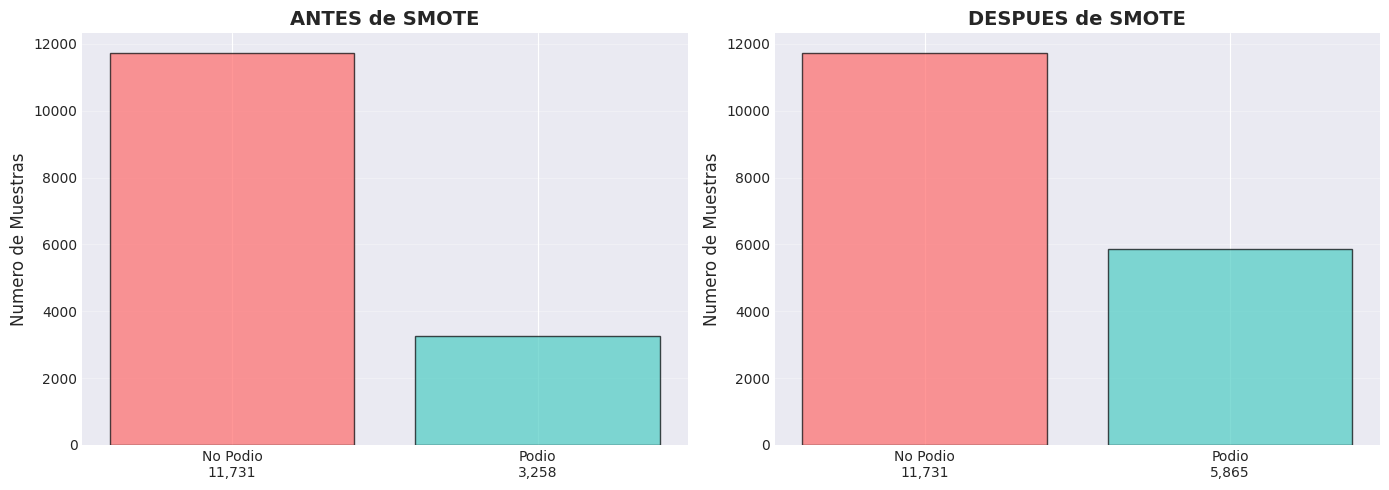


CONCLUSION: SMOTE mejora el balance sin perder informacion de la clase mayoritaria


In [61]:
# Visualizacion del efecto de SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de SMOTE
before_counts = [((y_train == 0).sum()), (y_train == 1).sum()]
before_labels = [f'No Podio\n{before_counts[0]:,}', f'Podio\n{before_counts[1]:,}']
axes[0].bar(before_labels, before_counts, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Numero de Muestras', fontsize=12)
axes[0].set_title('ANTES de SMOTE', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Despues de SMOTE
after_counts = [(y_train_smote == 0).sum(), (y_train_smote == 1).sum()]
after_labels = [f'No Podio\n{after_counts[0]:,}', f'Podio\n{after_counts[1]:,}']
axes[1].bar(after_labels, after_counts, color=['#FF6B6B', '#4ECDC4'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Numero de Muestras', fontsize=12)
axes[1].set_title('DESPUES de SMOTE', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCONCLUSION: SMOTE mejora el balance sin perder informacion de la clase mayoritaria")

---
## 14. Guardado de Datasets y Transformadores

In [62]:
print("Guardando datasets procesados y transformadores...")

# Guardar datasets originales (sin SMOTE)
X_train.to_csv(f'{OUTPUT_PATH}model4_X_train.csv', index=False)
X_test.to_csv(f'{OUTPUT_PATH}model4_X_test.csv', index=False)
np.save(f'{OUTPUT_PATH}model4_y_train.npy', y_train)
np.save(f'{OUTPUT_PATH}model4_y_test.npy', y_test)

print("  Datasets originales guardados:")
print("    - model4_X_train.csv")
print("    - model4_X_test.csv")
print("    - model4_y_train.npy")
print("    - model4_y_test.npy")

# Guardar version con SMOTE
pd.DataFrame(X_train_smote, columns=X_train.columns).to_csv(f'{OUTPUT_PATH}model4_X_train_smote.csv', index=False)
np.save(f'{OUTPUT_PATH}model4_y_train_smote.npy', y_train_smote)

print("\n  Datasets balanceados (SMOTE) guardados:")
print("    - model4_X_train_smote.csv")
print("    - model4_y_train_smote.npy")

# Guardar transformadores
joblib.dump(minmax_scaler, f'{OUTPUT_PATH}model4_minmax_scaler.pkl')
joblib.dump(standard_scaler, f'{OUTPUT_PATH}model4_standard_scaler.pkl')
joblib.dump(target_encoder, f'{OUTPUT_PATH}model4_target_encoder.pkl')

print("\n  Transformadores guardados:")
print("    - model4_minmax_scaler.pkl")
print("    - model4_standard_scaler.pkl")
print("    - model4_target_encoder.pkl")

print("\n" + "="*80)
print("PREPROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("="*80)

Guardando datasets procesados y transformadores...
  Datasets originales guardados:
    - model4_X_train.csv
    - model4_X_test.csv
    - model4_y_train.npy
    - model4_y_test.npy

  Datasets balanceados (SMOTE) guardados:
    - model4_X_train_smote.csv
    - model4_y_train_smote.npy

  Transformadores guardados:
    - model4_minmax_scaler.pkl
    - model4_standard_scaler.pkl
    - model4_target_encoder.pkl

PREPROCESAMIENTO COMPLETADO EXITOSAMENTE


---
## 15. Resumen Final del Preprocesamiento

In [63]:
print("\n" + "="*80)
print("RESUMEN FINAL - PREPROCESAMIENTO MODELO 4")
print("="*80)

print(f"\n1. DATASET TRAIN (Original):")
print(f"   Registros: {len(X_train):,}")
print(f"   Features: {len(X_train.columns)}")
print(f"   No Podio: {(y_train == 0).sum():,} ({100*(y_train == 0).mean():.2f}%)")
print(f"   Podio: {(y_train == 1).sum():,} ({100*(y_train == 1).mean():.2f}%)")

print(f"\n2. DATASET TRAIN (Balanceado con SMOTE):")
print(f"   Registros: {len(X_train_smote):,}")
print(f"   Features: {len(X_train.columns)}")
print(f"   No Podio: {(y_train_smote == 0).sum():,} ({100*(y_train_smote == 0).mean():.2f}%)")
print(f"   Podio: {(y_train_smote == 1).sum():,} ({100*(y_train_smote == 1).mean():.2f}%)")

print(f"\n3. DATASET TEST:")
print(f"   Registros: {len(X_test):,}")
print(f"   Features: {len(X_test.columns)}")
print(f"   No Podio: {(y_test == 0).sum():,} ({100*(y_test == 0).mean():.2f}%)")
print(f"   Podio: {(y_test == 1).sum():,} ({100*(y_test == 1).mean():.2f}%)")

print(f"\n4. TRANSFORMACIONES APLICADAS:")
print(f"   - MinMaxScaler: {len(minmax_features)} features")
print(f"   - StandardScaler: {len(standard_features)} features")
print(f"   - Target Encoding: {len(target_encoding_features)} features")
print(f"   - One-Hot Encoding: {len(onehot_features)} features")

print(f"\n5. DATA LEAKAGE:")
print(f"   - Variables eliminadas: 12")
print(f"   - Features historicas con shift(1): Previene leakage temporal")
print(f"   - Split temporal: Train (hasta 2022), Test (2023+)")

print(f"\n6. ARCHIVOS GENERADOS:")
print(f"   - 4 archivos de datos (train/test original)")
print(f"   - 2 archivos de datos balanceados (SMOTE)")
print(f"   - 3 transformadores (scalers, encoder)")

print("\n" + "="*80)
print("PROXIMO PASO: Entrenar modelos en 02_entrenamiento_modelos_podio.ipynb")
print("="*80)


RESUMEN FINAL - PREPROCESAMIENTO MODELO 4

1. DATASET TRAIN (Original):
   Registros: 14,989
   Features: 190
   No Podio: 11,731 (78.26%)
   Podio: 3,258 (21.74%)

2. DATASET TRAIN (Balanceado con SMOTE):
   Registros: 17,596
   Features: 190
   No Podio: 11,731 (66.67%)
   Podio: 5,865 (33.33%)

3. DATASET TEST:
   Registros: 602
   Features: 190
   No Podio: 500 (83.06%)
   Podio: 102 (16.94%)

4. TRANSFORMACIONES APLICADAS:
   - MinMaxScaler: 10 features
   - StandardScaler: 5 features
   - Target Encoding: 3 features
   - One-Hot Encoding: 4 features

5. DATA LEAKAGE:
   - Variables eliminadas: 12
   - Features historicas con shift(1): Previene leakage temporal
   - Split temporal: Train (hasta 2022), Test (2023+)

6. ARCHIVOS GENERADOS:
   - 4 archivos de datos (train/test original)
   - 2 archivos de datos balanceados (SMOTE)
   - 3 transformadores (scalers, encoder)

PROXIMO PASO: Entrenar modelos en 02_entrenamiento_modelos_podio.ipynb
